Дан тренировочный датасет с текстами сообщений из
мессенджера на английском языке. Для каждого из них
проставлен флаг того, является ли сообщение СПАМом.
Так же дан тестовый датасет с такими же текстами
сообщений, но без флага. На нем нужно будет
проскорить модель и приложить результаты.
Данные лежат по ссылке

Поля датасета:

• text_type - целевая переменная, флаг СПАМ/не
СПАМ

• text - текст сообщения.

Задача:

• провести базовую аналитику по имеющимся
данным,

• обучить модель по тексту сообщения определять,
является ли ее содержимое СПАМом (ожидается,
что будут опробованы несколько подходов, из
которых аргументированно выбирается наилучший;
можно использовать любую библиотеку или
Фреймворк),

• целевой метрикой при оценке работы модели будет
ROC-AUC score,

• произвести скоринг лучшей моделью тестовых
данных, а результат записать в в виде
таблицы с колонками score и text;

• выложить код на jupyter notebook и
результирующий файл со скорами модели
на https://github.com отдельным проектом и
поделиться ссылкой в поле для ответа.



Импорт библиотек

In [106]:
from google.colab import drive
drive.mount('/content/drive')
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os,random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.losses import categorical_crossentropy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout, Dense, Input,SpatialDropout1D, concatenate, Bidirectional, BatchNormalization,SimpleRNN, Embedding,Activation, GRU, Conv1D, Flatten, LSTM
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузка тренировочного датасета

In [107]:
path = 'drive/MyDrive/Colab Notebooks/VKintern/'
file_name = 'train_spam.csv'
punctuation_list = ['.',',',':','!','?','/','@','$','+','-']
df = pd.read_csv(path+file_name)
data = df.values #  (16278, 2)
df.columns, data.shape

(Index(['text_type', 'text'], dtype='object'), (16278, 2))

Функция для замены латинских букв в один диапазон кодировки

Смайлики обосабливаются пробелами

Цифры заменяются на '0'

In [108]:
def treat_message(text):
  text = text.split()
  for j,t in enumerate(text):
    for chri in range(len(text[j])):
      c = ord(text[j][chri])
      if 119808<=c<=120483:
        text[j] = text[j][:chri]+chr(c%26+97)+text[j][chri+1:]
      elif 127462<=c<=127487:
        text[j] = text[j][:chri]+chr(c%26+97)+text[j][chri+1:]
      elif 127280<=c<=127305: # ===================================================================
        text[j] = text[j][:chri]+chr(c%26-10+97)+text[j][chri+1:]
      elif 127344<=c<=127369: # ===================================================================
        text[j] = text[j][:chri]+chr(c%26-22+97)+text[j][chri+1:]
      elif 127312<=c<=127337: # ===================================================================
        text[j] = text[j][:chri]+chr(c%26-16+97)+text[j][chri+1:]
      elif 43898<=c<=43923: # ===================================================================
        text[j] = text[j][:chri]+chr(c%26-10+97)+text[j][chri+1:]
      elif c==42801:
        text[j] = text[j][:chri]+'s'+text[j][chri+1:]
      elif c==42800:
        text[j] = text[j][:chri]+'f'+text[j][chri+1:]
    di = 0
    for chri in range(len(text[j])):
      c = ord(text[j][chri+di])
      if c>8000 or chr(c) in punctuation_list:
        text[j] = text[j][:chri+di]+' '+text[j][chri+di]+' '+text[j][chri+di+1:]
        di+=2
      if 48<=c<=57:
        text[j] = text[j][:chri+di]+' '+'0'+' '+text[j][chri+di+1:]
        di+=2
  text = ' '.join(text)
  return text

Создание раздельных списков скам сообщений и обычных

In [109]:
spam = []
ham = []
for i in data:
  text = i[1]
  text = treat_message(text)
  if i[0]=='spam':
    spam.append(text)
  else:
    ham.append(text)
print(max([len(i.split()) for i in ham+spam]))
len(spam),len(ham)

599


(4809, 11469)

Создается 3 словаря частотности: словарь спам-сообщений, словарь для нормальных сообщений и общий словарь

In [110]:
tokenizer = Tokenizer(num_words=100000)
z = spam[0]
tokenizer.fit_on_texts(ham)
tham = tokenizer.word_index
tokenizer.fit_on_texts(spam)
tspam = tokenizer.word_index
tokenizer.fit_on_texts(spam+ham)
d = tokenizer.word_index

In [111]:
file_name = 'test_spam.csv'
df = pd.read_csv(path+file_name)
data = df.values
task = []
for i in data:
  text = i[0]
  text = treat_message(text)
  task.append(text)
print(max([len(i.split()) for i in task]))
len(task)

520


4070

In [112]:
task = [task[i].split() for i in range(len(task))]
ham = [ham[i].split() for i in range(len(ham))]
spam = [spam[i].split() for i in range(len(spam))]

Замена обработанных слов сообщений на токены

Если порядок слова хотя бы в одном из словарей меньше 500, то берется его токен из общего словаря, в противном случае ему присваивается нулевой токен

In [113]:
def select_token(i,x):
  for j in i:
    if j not in punctuation_list:
      if j =='0':
        if x[-1]!=[]:
         if x[-1][-1]!=1:
          x[-1].append(1)
        continue
      if j in tham:
        if tham[j]<=500:
          x[-1].append(d[j])
          continue
      if j in tspam:
        if tspam[j]<=500:
          x[-1].append(d[j])
          continue
      x[-1].append(0)
    if j=='.':
          x[-1].append(2000)
          continue
  return x

In [114]:
xham = []
xspam = []
xtask = []
for i in ham:
  xham.append([])
  xham = select_token(i,xham)
for i in spam:
  xspam.append([])
  xspam = select_token(i,xspam)
for i in task:
  xtask.append([])
  xtask = select_token(i,xtask)
print(len(xham),len(xspam),len(xtask))

11469 4809 4070


Иллюстрация замены слов из списка спама

In [115]:
ind = {value: key for key, value in d.items()}
k = random.randint(0,1000)
[ind[i] for j,i in enumerate(xspam[k]) if i!=0],spam[k]

(['access',
  'to',
  'account',
  'as',
  'part',
  'of',
  'our',
  'we',
  'in',
  'system',
  'we',
  'the',
  'following',
  'issue',
  'on',
  'your',
  'account',
  'we',
  'would',
  'like',
  'to',
  'that',
  'your',
  'account',
  'was',
  'not',
  'by',
  'because',
  'the',
  'of',
  'your',
  'account',
  'is',
  'our',
  'we',
  'have',
  'access',
  'to',
  'account',
  'we',
  'know',
  'that',
  'this',
  'may',
  'be',
  'an',
  'but',
  'that',
  'this',
  'is',
  'for',
  'your',
  'case',
  'id',
  'number',
  '0',
  'to',
  'review',
  'your',
  'account',
  'and',
  'some',
  'or',
  'all',
  'of',
  'the',
  'information',
  'that',
  'used',
  'to',
  'make',
  'its',
  'to',
  'your',
  'account',
  'access',
  'please',
  'visit',
  'the',
  'or',
  'copy',
  'this',
  'link',
  'and',
  'it',
  'in',
  'the',
  'internet'],
 ['limited',
  'access',
  'to',
  'sensitive',
  'paypal',
  'account',
  'features',
  'as',
  'part',
  'of',
  'our',
  'security',

Разделение выборок на тестовую, валидационную и тренировочную.

В проверочных выборках соотношение сообщений со спамом и нормальных 1 к 1, чтобы применять метрику точности.

In [116]:
print(max([len(i) for i in xspam]))
m = 600
label = np.array([1]*(len(xspam)-1000)+[0]*(len(xham)-1000))
test_label = np.array([1]*500+[0]*500)
val_label = np.array([1]*500+[0]*500)
x = []
for i in range(len(xtask)):
  xtask[i] = xtask[i]+[0]*(m-len(xtask[i]))
for i in xspam:
  x.append(i+[0]*(m-len(i)))
x_test = x[:500]
x_val = x[-500:]
x = x[500:-500]
for i in xham:
  x.append(i+[0]*(m-len(i)))
x_test+=x[-500:]
x_val += x[-1000:-500]
x = x[:-1000]
x = np.array(x)
x_val = np.array(x_val)
x_test = np.array(x_test)
r = [range(1000)]
random.shuffle(r)
x_test = x_test[r].reshape((1000,600))
xtask = np.array(xtask)
x_val = x_val[r].reshape((1000,600))
test_label = test_label[r].reshape(-1)
val_label = val_label[r].reshape(-1)
r = [range(x.shape[0])]
random.shuffle(r)
x = x[r].reshape((14278,600))
label = label[r].reshape(-1)

label.shape, x.shape, x_test.shape, test_label.shape, x_val.shape, val_label.shape, xtask.shape


569


((14278,),
 (14278, 600),
 (1000, 600),
 (1000,),
 (1000, 600),
 (1000,),
 (4070, 600))

Лучше всего подошла модель с двунаправленными lstm слоями

In [117]:
def lstm_model():
  input = Input((600))
  f = Embedding(input_dim = 2001,output_dim=8)(input)
  f = SpatialDropout1D(0.2)(f)
  f = Bidirectional(LSTM(32,return_sequences=True))(f)
  f = Bidirectional(LSTM(32))(f)
  f = Dense(64)(f)
  f = Dense(1,activation='sigmoid')(f)
  model = Model(input,f)
  return model
model = lstm_model()
model.compile(loss='binary_crossentropy',optimizer=Adam(0.0003),metrics='accuracy')
print('Число параметров:',
      sum([np.array(i).reshape(-1).shape[0] for i in model.weights]))
model.summary()

Число параметров: 55561
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 600, 8)            16008     
                                                                 
 spatial_dropout1d_7 (Spati  (None, 600, 8)            0         
 alDropout1D)                                                    
                                                                 
 bidirectional_16 (Bidirect  (None, 600, 64)           10496     
 ional)                                                          
                                                                 
 bidirectional_17 (Bidirect  (None, 64)                24832     
 ional)                                                          
                                   

Тренировка

In [131]:
h = model.fit(x,label.reshape(-1),
              batch_size=128,
              epochs = 40,
              validation_data=(x_val,val_label))
# 0.932

Epoch 1/40
112/112 [==============================] - 9s 81ms/step - loss: 0.0922 - accuracy: 0.9679 - val_loss: 0.2565 - val_accuracy: 0.9200
Epoch 2/40
112/112 [==============================] - 7s 65ms/step - loss: 0.0856 - accuracy: 0.9693 - val_loss: 0.2395 - val_accuracy: 0.9210
Epoch 3/40
112/112 [==============================] - 8s 71ms/step - loss: 0.0832 - accuracy: 0.9699 - val_loss: 0.2620 - val_accuracy: 0.9210
Epoch 4/40
112/112 [==============================] - 7s 66ms/step - loss: 0.0823 - accuracy: 0.9709 - val_loss: 0.2639 - val_accuracy: 0.9230
Epoch 5/40
112/112 [==============================] - 8s 70ms/step - loss: 0.0819 - accuracy: 0.9714 - val_loss: 0.2648 - val_accuracy: 0.9170
Epoch 6/40
112/112 [==============================] - 8s 71ms/step - loss: 0.0769 - accuracy: 0.9731 - val_loss: 0.2859 - val_accuracy: 0.9190
Epoch 7/40
112/112 [==============================] - 7s 64ms/step - loss: 0.0767 - accuracy: 0.9742 - val_loss: 0.2802 - val_accuracy: 0.9230

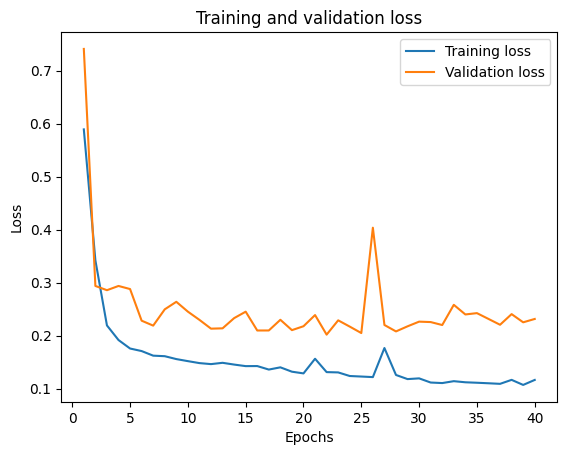

In [119]:
# Визуализация процесса обучения
history_dict = h.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Оценка модели на тестовой выборке

In [133]:
p = model.predict(x_test).reshape(-1)  # Предсказание тестовой выборки
1-np.sum(np.abs(test_label-np.round(p.reshape(-1))))/np.shape(test_label)[0]

32/32 [==============================] - 1s 29ms/step


0.928

Оценка заданной на проверку выборки

In [134]:
p = model.predict(xtask).reshape(-1)

128/128 [==============================] - 4s 31ms/step


Запись ответа

In [135]:
a = ['ham','spam']
with open('answer.csv','w') as f:
  print('type','score','message',file = f)
  for i in range(len(p)):
    print(a[int(np.round(p[i]))],',',p[i],',',data[i][0]  ,file=f)